In [1]:
#调用torch库
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
#调用numpy库
import numpy as np
#调用matplotlib库
import matplotlib.pyplot as plt
#调用random库
import random

In [2]:
train_dataset = torchvision.datasets.MNIST(root="../Datasets/MNIST", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="../Datasets/MNIST", train=False, transform=transforms.ToTensor())

In [3]:
num_workers = 16
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [4]:
#使用课上给出的优化函数进行参数的学习优化
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

# 损失函数使用手动实现的交叉熵损失函数
# y_hat为模型的预测值，而y为真实标签
def Loss(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [30]:
class Feedforward_multiclass:
    def __init__(self, image_size, class_num, opt, device, hidden=100):
        self.w_in = torch.tensor(np.random.normal(0, 0.01, (image_size * image_size, hidden)), dtype=torch.float32).to(device)
        self.b_in = torch.zeros(hidden, dtype=torch.float32).to(device)
        self.w_in.requires_grad_(requires_grad=True)
        self.b_in.requires_grad_(requires_grad=True) 

        self.w_out = torch.tensor(np.random.normal(0, 0.01, (hidden, class_num)), dtype=torch.float32).to(device)
        self.b_out = torch.zeros(class_num, dtype=torch.float32).to(device)
        self.w_out.requires_grad_(requires_grad=True)
        self.b_out.requires_grad_(requires_grad=True) 

        self.opt = opt

    def relu(self, x):
        x[x < 0.] = 0.
        return x 

    def softmax(self, x):
        x_exp = torch.exp(x)
        partition = x_exp.sum(1, keepdim=True)
        return x_exp / partition


    def forward(self, x):
        x = torch.matmul(x, self.w_in) + self.b_in
        x = self.relu(x)
        x = torch.matmul(x, self.w_out) + self.b_out
        return self.softmax(x)

    def learn(self, lr, bs):
        self.opt([self.w_in, self.b_in, self.w_out, self.b_out], lr, bs)

    def reset_grad(self):
        self.w_in.grad.data.zero_()
        self.b_in.grad.data.zero_()
        self.w_out.grad.data.zero_()
        self.b_out.grad.data.zero_()

In [6]:
# 计算预测的准确度
def accuracy(y_hat, y):  #@save
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [18]:
def l2_penalty(w):
    return (w**2).sum() / 2

加入L2正则进行约束

In [32]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'
opt = sgd
loss = Loss
net = Feedforward_multiclass(image_size, class_num, sgd, device)
train_loss_list = []
test_loss_list = []
test_acc_list = []
lambd = 0.01
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        # pre-proccess
        train_x = train_x.squeeze(1)
        train_x = train_x.flatten(1, 2)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label) + lambd * l2_penalty(net.w_in) + lambd * l2_penalty(net.w_out)
        l = l.sum()
        l.backward()
        net.learn(lr, batch_size)
        net.reset_grad()
        train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            # pre-proccess
            test_x = test_x.squeeze(1)
            test_x = test_x.flatten(1, 2)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list.append(total_loss.item())
        test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

epoch: 1, total loss: 11.739163, total_acc: 0.904353
epoch: 2, total loss: 10.376230, total_acc: 0.914936
epoch: 3, total loss: 9.657497, total_acc: 0.921825
epoch: 4, total loss: 9.257785, total_acc: 0.925619
epoch: 5, total loss: 9.010750, total_acc: 0.929313
epoch: 6, total loss: 8.925654, total_acc: 0.926917
epoch: 7, total loss: 8.649938, total_acc: 0.932408
epoch: 8, total loss: 8.570171, total_acc: 0.931709
epoch: 9, total loss: 8.663195, total_acc: 0.928015
epoch: 10, total loss: 8.424509, total_acc: 0.934305
epoch: 11, total loss: 8.461718, total_acc: 0.933207
epoch: 12, total loss: 8.476876, total_acc: 0.933706
epoch: 13, total loss: 8.356206, total_acc: 0.936601
epoch: 14, total loss: 8.140080, total_acc: 0.936901
epoch: 15, total loss: 8.183252, total_acc: 0.937899
epoch: 16, total loss: 8.152566, total_acc: 0.936901
epoch: 17, total loss: 8.147599, total_acc: 0.937400
epoch: 18, total loss: 8.160355, total_acc: 0.935803
epoch: 19, total loss: 8.127863, total_acc: 0.935903


验证损失变化

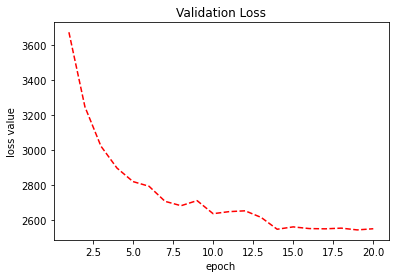

In [33]:
x = [i + 1 for i in range(len(test_loss_list))]
y = test_loss_list
l1 = plt.plot(x, y, 'r--', label='test_loss')

plt.title('Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

模型中加入dropout进行约束

In [38]:
class Feedforward_multiclass:
    def __init__(self, image_size, class_num, drop_out, opt, device, hidden=100):
        self.w_in = torch.tensor(np.random.normal(0, 0.01, (image_size * image_size, hidden)), dtype=torch.float32).to(device)
        self.b_in = torch.zeros(hidden, dtype=torch.float32).to(device)
        self.w_in.requires_grad_(requires_grad=True)
        self.b_in.requires_grad_(requires_grad=True) 

        self.w_out = torch.tensor(np.random.normal(0, 0.01, (hidden, class_num)), dtype=torch.float32).to(device)
        self.b_out = torch.zeros(class_num, dtype=torch.float32).to(device)
        self.w_out.requires_grad_(requires_grad=True)
        self.b_out.requires_grad_(requires_grad=True) 

        self.dropout_rate = drop_out
        self.opt = opt

    def relu(self, x):
        x[x < 0.] = 0.
        return x 

    def softmax(self, x):
        x_exp = torch.exp(x)
        partition = x_exp.sum(1, keepdim=True)
        return x_exp / partition

    def dropout(self, x):
        keep_prob = 1 - self.dropout_rate
        if keep_prob == 0:
            return torch.zeros_like(x, device=x.device)
        mask = (torch.rand(x.shape, device=x.device) < keep_prob).float()
        return mask * x / keep_prob

    def forward(self, x):
        x = torch.matmul(x, self.w_in) + self.b_in
        x = self.relu(x)
        x = self.dropout(x)
        x = torch.matmul(x, self.w_out) + self.b_out
        return self.softmax(x)

    def learn(self, lr, bs):
        self.opt([self.w_in, self.b_in, self.w_out, self.b_out], lr, bs)

    def reset_grad(self):
        self.w_in.grad.data.zero_()
        self.b_in.grad.data.zero_()
        self.w_out.grad.data.zero_()
        self.b_out.grad.data.zero_()

In [39]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'
opt = sgd
loss = Loss
net = Feedforward_multiclass(image_size, class_num, 0.5, sgd, device)
train_loss_list = []
test_loss_list = []
test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        # pre-proccess
        train_x = train_x.squeeze(1)
        train_x = train_x.flatten(1, 2)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label)
        l = l.sum()
        l.backward()
        net.learn(lr, batch_size)
        net.reset_grad()
        train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            # pre-proccess
            test_x = test_x.squeeze(1)
            test_x = test_x.flatten(1, 2)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list.append(total_loss.item())
        test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

epoch: 1, total loss: 13.918852, total_acc: 0.878195
epoch: 2, total loss: 10.686533, total_acc: 0.903155
epoch: 3, total loss: 9.241076, total_acc: 0.917432
epoch: 4, total loss: 8.298319, total_acc: 0.923822
epoch: 5, total loss: 7.470752, total_acc: 0.931310
epoch: 6, total loss: 7.180047, total_acc: 0.933506
epoch: 7, total loss: 6.692270, total_acc: 0.938598
epoch: 8, total loss: 6.403076, total_acc: 0.940595
epoch: 9, total loss: 6.484801, total_acc: 0.940196
epoch: 10, total loss: 6.359005, total_acc: 0.940595
epoch: 11, total loss: 6.169573, total_acc: 0.942093
epoch: 12, total loss: 5.952738, total_acc: 0.944189
epoch: 13, total loss: 5.859929, total_acc: 0.946885
epoch: 14, total loss: 6.003254, total_acc: 0.944988
epoch: 15, total loss: 5.528094, total_acc: 0.950080
epoch: 16, total loss: 5.839468, total_acc: 0.947784
epoch: 17, total loss: 5.612897, total_acc: 0.950180
epoch: 18, total loss: 5.530610, total_acc: 0.949980
epoch: 19, total loss: 5.461634, total_acc: 0.949481


验证损失变化

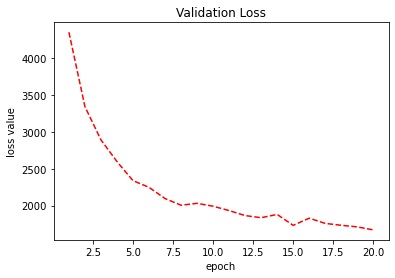

In [40]:
x = [i + 1 for i in range(len(test_loss_list))]
y = test_loss_list
l1 = plt.plot(x, y, 'r--', label='test_loss')

plt.title('Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

利用torch自带优化器实现L2正则

In [36]:
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Feedforward(nn.Module):
    def __init__(self, image_size, class_num, layer_num, hidden_dim, activation, drop_out=0):
        super(Feedforward, self).__init__()

        self.flatten = FlattenLayer()
        self.linear_in = nn.Linear(image_size*image_size, hidden_dim)
        hidden_layers = []
        hidden_layers.append(activation)
        if drop_out > 0:
            hidden_layers.append(nn.Dropout(p=drop_out))
        
        for _ in range(layer_num - 1):
            hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layers.append(activation)
            if drop_out > 0:
                hidden_layers.append(nn.Dropout(p=drop_out))
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.linear_out = nn.Linear(hidden_dim, class_num)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_in(x)
        x = self.hidden_layers(x)
        x = self.linear_out(x)
        return self.softmax(x)

In [44]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'

layer_num  = 1   # 隐藏层数为1层
hidden_dim = 100 # 隐藏层单元数为10
drop_out   = 0    # 不设置dropout
activation = nn.ReLU() #激活函数选用ReLU
wd = 0.01  #惩罚系数选为0.01
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03, weight_decay=wd) #在weight decay处进行设置
loss = nn.CrossEntropyLoss()

relu_train_loss_list = []
relu_test_loss_list = []
relu_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        relu_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        relu_test_loss_list.append(total_loss.item())
        relu_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_1364635/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.798728, total_acc: 0.737720
epoch: 2, total loss: 1.742050, total_acc: 0.819089
epoch: 3, total loss: 1.702451, total_acc: 0.832768
epoch: 4, total loss: 1.693555, total_acc: 0.835663
epoch: 5, total loss: 1.691407, total_acc: 0.835663
epoch: 6, total loss: 1.690773, total_acc: 0.837859
epoch: 7, total loss: 1.689760, total_acc: 0.838658
epoch: 8, total loss: 1.689410, total_acc: 0.837460
epoch: 9, total loss: 1.688345, total_acc: 0.838259
epoch: 10, total loss: 1.683626, total_acc: 0.845946
epoch: 11, total loss: 1.652238, total_acc: 0.892372
epoch: 12, total loss: 1.645478, total_acc: 0.895966
epoch: 13, total loss: 1.643020, total_acc: 0.898562
epoch: 14, total loss: 1.642894, total_acc: 0.899461
epoch: 15, total loss: 1.640440, total_acc: 0.899860
epoch: 16, total loss: 1.639749, total_acc: 0.902955
epoch: 17, total loss: 1.639820, total_acc: 0.902556
epoch: 18, total loss: 1.639041, total_acc: 0.902855
epoch: 19, total loss: 1.638271, total_acc: 0.902157
ep

In [45]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'

layer_num  = 1   # 隐藏层数为1层
hidden_dim = 100 # 隐藏层单元数为10
drop_out   = 0    # 不设置dropout
activation = nn.ReLU() #激活函数选用ReLU
wd = 0.005  #惩罚系数选为0.005
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03, weight_decay=wd) #在weight decay处进行设置
loss = nn.CrossEntropyLoss()

relu2_train_loss_list = []
relu2_test_loss_list = []
relu2_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        relu2_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        relu2_test_loss_list.append(total_loss.item())
        relu2_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_1364635/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.743027, total_acc: 0.806110
epoch: 2, total loss: 1.673170, total_acc: 0.834065
epoch: 3, total loss: 1.662790, total_acc: 0.839058
epoch: 4, total loss: 1.651278, total_acc: 0.861621
epoch: 5, total loss: 1.613012, total_acc: 0.899161
epoch: 6, total loss: 1.604303, total_acc: 0.906350
epoch: 7, total loss: 1.601392, total_acc: 0.908147
epoch: 8, total loss: 1.599800, total_acc: 0.909645
epoch: 9, total loss: 1.598150, total_acc: 0.911142
epoch: 10, total loss: 1.596546, total_acc: 0.913938
epoch: 11, total loss: 1.596078, total_acc: 0.912340
epoch: 12, total loss: 1.594677, total_acc: 0.916633
epoch: 13, total loss: 1.594551, total_acc: 0.915435
epoch: 14, total loss: 1.593611, total_acc: 0.917033
epoch: 15, total loss: 1.593344, total_acc: 0.917133
epoch: 16, total loss: 1.592076, total_acc: 0.918830
epoch: 17, total loss: 1.591430, total_acc: 0.920727
epoch: 18, total loss: 1.592086, total_acc: 0.918131
epoch: 19, total loss: 1.590738, total_acc: 0.921226
ep

In [46]:
image_size = 28
class_num = 10
device = 'cuda:0'

layer_num  = 1   # 隐藏层数为1层
hidden_dim = 100 # 隐藏层单元数为10
drop_out   = 0    # 不设置dropout
activation = nn.ReLU() #激活函数选用ReLU
wd = 0.001  #惩罚系数选为0.001
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03, weight_decay=wd) #在weight decay处进行设置
loss = nn.CrossEntropyLoss()

relu3_train_loss_list = []
relu3_test_loss_list = []
relu3_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        relu3_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        relu3_test_loss_list.append(total_loss.item())
        relu3_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_1364635/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.712022, total_acc: 0.817292
epoch: 2, total loss: 1.650101, total_acc: 0.838359
epoch: 3, total loss: 1.637230, total_acc: 0.843450
epoch: 4, total loss: 1.631142, total_acc: 0.845647
epoch: 5, total loss: 1.612033, total_acc: 0.877696
epoch: 6, total loss: 1.575240, total_acc: 0.910144
epoch: 7, total loss: 1.565301, total_acc: 0.917831
epoch: 8, total loss: 1.559225, total_acc: 0.922324
epoch: 9, total loss: 1.556092, total_acc: 0.924121
epoch: 10, total loss: 1.553040, total_acc: 0.927716
epoch: 11, total loss: 1.551671, total_acc: 0.927516
epoch: 12, total loss: 1.549331, total_acc: 0.930212
epoch: 13, total loss: 1.547131, total_acc: 0.932009
epoch: 14, total loss: 1.545787, total_acc: 0.933407
epoch: 15, total loss: 1.544200, total_acc: 0.935004
epoch: 16, total loss: 1.543326, total_acc: 0.936801
epoch: 17, total loss: 1.542821, total_acc: 0.937300
epoch: 18, total loss: 1.541132, total_acc: 0.938698
epoch: 19, total loss: 1.540141, total_acc: 0.938498
ep

探究惩罚项的权重对实验结果的影响（可用loss曲线进行展示）

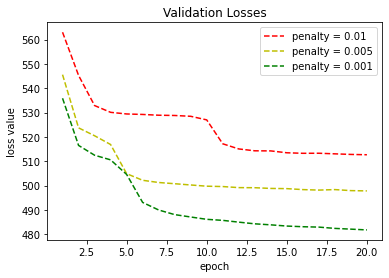

In [47]:
x = [i + 1 for i in range(len(relu_test_loss_list))]
y1 = relu_test_loss_list
y2 = relu2_test_loss_list
y3 = relu3_test_loss_list
l1 = plt.plot(x, y1, 'r--', label='penalty = 0.01')
l2 = plt.plot(x, y2, 'y--', label='penalty = 0.005')
l3 = plt.plot(x, y3, 'g--', label='penalty = 0.001')

plt.title('Validation Losses')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

利用torch自带优化器实现dropout

In [48]:
image_size = 28
class_num = 10
device = 'cuda:0'

layer_num  = 1   # 隐藏层数为1层
hidden_dim = 100 # 隐藏层单元数为10
drop_out   = 0.3    # 设置dropout rate 0.3
activation = nn.ReLU() #激活函数选用ReLU
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

dp3_train_loss_list = []
dp3_test_loss_list = []
dp3_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        dp3_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        dp3_test_loss_list.append(total_loss.item())
        dp3_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_1364635/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.751507, total_acc: 0.780252
epoch: 2, total loss: 1.670179, total_acc: 0.817792
epoch: 3, total loss: 1.650648, total_acc: 0.828275
epoch: 4, total loss: 1.639189, total_acc: 0.836362
epoch: 5, total loss: 1.605046, total_acc: 0.883986
epoch: 6, total loss: 1.582783, total_acc: 0.897564
epoch: 7, total loss: 1.571073, total_acc: 0.905451
epoch: 8, total loss: 1.564301, total_acc: 0.911542
epoch: 9, total loss: 1.558213, total_acc: 0.918031
epoch: 10, total loss: 1.553121, total_acc: 0.919728
epoch: 11, total loss: 1.550828, total_acc: 0.920527
epoch: 12, total loss: 1.548017, total_acc: 0.923722
epoch: 13, total loss: 1.543696, total_acc: 0.927716
epoch: 14, total loss: 1.541705, total_acc: 0.928714
epoch: 15, total loss: 1.539446, total_acc: 0.931410
epoch: 16, total loss: 1.538072, total_acc: 0.932308
epoch: 17, total loss: 1.534930, total_acc: 0.936002
epoch: 18, total loss: 1.533710, total_acc: 0.936402
epoch: 19, total loss: 1.534758, total_acc: 0.934605
ep

In [49]:
image_size = 28
class_num = 10
device = 'cuda:0'

layer_num  = 1   # 隐藏层数为1层
hidden_dim = 100 # 隐藏层单元数为10
drop_out   = 0.5    # 设置dropout rate 0.5
activation = nn.ReLU() #激活函数选用ReLU
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

dp5_train_loss_list = []
dp5_test_loss_list = []
dp5_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        dp5_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        dp5_test_loss_list.append(total_loss.item())
        dp5_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_1364635/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.775633, total_acc: 0.752296
epoch: 2, total loss: 1.687999, total_acc: 0.801418
epoch: 3, total loss: 1.663803, total_acc: 0.818690
epoch: 4, total loss: 1.651702, total_acc: 0.824681
epoch: 5, total loss: 1.640304, total_acc: 0.832768
epoch: 6, total loss: 1.603128, total_acc: 0.884385
epoch: 7, total loss: 1.587139, total_acc: 0.891873
epoch: 8, total loss: 1.579043, total_acc: 0.899760
epoch: 9, total loss: 1.573943, total_acc: 0.904253
epoch: 10, total loss: 1.569901, total_acc: 0.905351
epoch: 11, total loss: 1.565573, total_acc: 0.908147
epoch: 12, total loss: 1.560987, total_acc: 0.911641
epoch: 13, total loss: 1.559652, total_acc: 0.913638
epoch: 14, total loss: 1.557268, total_acc: 0.913838
epoch: 15, total loss: 1.552656, total_acc: 0.919030
epoch: 16, total loss: 1.549815, total_acc: 0.923223
epoch: 17, total loss: 1.549319, total_acc: 0.922724
epoch: 18, total loss: 1.549573, total_acc: 0.920228
epoch: 19, total loss: 1.545187, total_acc: 0.926118
ep

In [50]:
image_size = 28
class_num = 10
device = 'cuda:0'

layer_num  = 1   # 隐藏层数为1层
hidden_dim = 100 # 隐藏层单元数为10
drop_out   = 0.7    # 设置dropout rate 0.7
activation = nn.ReLU() #激活函数选用ReLU
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

dp7_train_loss_list = []
dp7_test_loss_list = []
dp7_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        dp7_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        dp7_test_loss_list.append(total_loss.item())
        dp7_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_1364635/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.883101, total_acc: 0.620008
epoch: 2, total loss: 1.745995, total_acc: 0.762280
epoch: 3, total loss: 1.705767, total_acc: 0.785044
epoch: 4, total loss: 1.687772, total_acc: 0.794728
epoch: 5, total loss: 1.674889, total_acc: 0.807109
epoch: 6, total loss: 1.669154, total_acc: 0.811202
epoch: 7, total loss: 1.661292, total_acc: 0.813598
epoch: 8, total loss: 1.648680, total_acc: 0.829473
epoch: 9, total loss: 1.622481, total_acc: 0.858826
epoch: 10, total loss: 1.610350, total_acc: 0.871605
epoch: 11, total loss: 1.602118, total_acc: 0.875300
epoch: 12, total loss: 1.599078, total_acc: 0.879193
epoch: 13, total loss: 1.597031, total_acc: 0.879792
epoch: 14, total loss: 1.591583, total_acc: 0.884585
epoch: 15, total loss: 1.591537, total_acc: 0.883287
epoch: 16, total loss: 1.584936, total_acc: 0.889577
epoch: 17, total loss: 1.582900, total_acc: 0.889876
epoch: 18, total loss: 1.584902, total_acc: 0.889577
epoch: 19, total loss: 1.578548, total_acc: 0.893770
ep

 探究不同丢弃率对实验结果的影响（可用loss曲线进行展示）

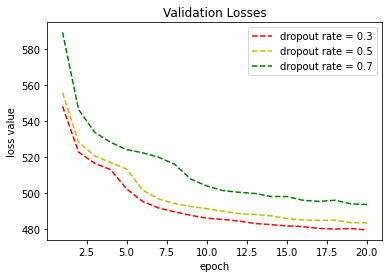

In [52]:
x = [i + 1 for i in range(len(dp3_test_loss_list))]
y1 = dp3_test_loss_list
y2 = dp5_test_loss_list
y3 = dp7_test_loss_list
l1 = plt.plot(x, y1, 'r--', label='dropout rate = 0.3')
l2 = plt.plot(x, y2, 'y--', label='dropout rate = 0.5')
l3 = plt.plot(x, y3, 'g--', label='dropout rate = 0.7')

plt.title('Validation Losses')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()